In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Reading Raw Data From DB

In [ ]:
record = pd.read_sql("select * from messages where name like '%RWP%' and subtopic like '%telemetry%' and unix_time >= timestamp '2021-09-01 00:00:00' and unix_time < timestamp '2021-10-07 00:00:00' order by unix_time asc;", con=connection)
# record = pd.read_sql("select * from messages where name like '%RWP%' and subtopic like '%telemetry%' order by unix_time asc;", con=connection)
# record = pd.read_csv('jazz_raw_data.csv')

### Data Description

In [ ]:
param_list = record['name'].unique()
print(len(param_list))

77


In [ ]:
variables = locals()
raw_data_df = pd.DataFrame(columns = ['Date', 'time'])
count = 1
for parameter in param_list:
  
  ## defining dataframe name ;
  if parameter == 'RWP1363:energy_meter-5--000000006a4ed817:total_instantaneous_real_power':
    df_name = 'power_source'
  else:
    df_name = parameter.split(':')[-1]
  hw_id = parameter.split(':')[1].split('-')[0]+parameter.split(':')[1].split('-')[1]
  df_name = df_name.replace('-','_').replace('.','_') 
  
  # discard if parameter is hw_code
  if (df_name) not in  ('hw_code','Input-4.1-Anomlous'):
    print( 'Parameter ' , str(count),': ',parameter)
    df_name = df_name+'_'+str(hw_id)
    df = record[record['name'] == parameter]
    df = df.sort_values(by="unix_time").reset_index(drop=True)

    import datetime as dt
    df['Date'] = df['unix_time'].dt.date
    df['Time'] = df['unix_time'].dt.time
    df['time'] = pd.to_datetime(df['Time'].astype(str).str[:-3]+':00').dt.time
    df['hour'] = pd.to_datetime(df['Time'].astype(str).str[:-6]+':00').dt.time

    new_df = pd.DataFrame(df.groupby(["Date","time"]).last()).reset_index()
    print('Actual number of Samples ',len(new_df))
    final_df = new_df[['Date','time','value']].rename({'value': df_name}, axis=1)

    raw_data_df = final_df.merge(raw_data_df, on =['Date', 'time'], how='outer')
    print('Samples after merginig ', len(raw_data_df))
    print('Dataframe name ', "df_{0}".format(df_name))
    count = count+1
    
    print('\n')
    variables["df_{0}_".format(df_name)] = new_df


Parameter  1 :  RWP1363:io-3--000000006a4ed817:Input-4.1
Actual number of Samples  48117
Samples after merginig  48117
Dataframe name  df_Input_4_1_io3


Parameter  2 :  RWP1363:io-3--000000006a4ed817:ac_ct_current
Actual number of Samples  50588
Samples after merginig  50989
Dataframe name  df_ac_ct_current_io3


Parameter  3 :  RWP1363:io-3--000000006a4ed817:gen_run_status
Actual number of Samples  49365
Samples after merginig  51144
Dataframe name  df_gen_run_status_io3


Parameter  4 :  RWP1363:io-3--000000006a4ed817:Input-8
Actual number of Samples  49589
Samples after merginig  51147
Dataframe name  df_Input_8_io3


Parameter  5 :  RWP1363:io-3--000000006a4ed817:ac_ct_voltage
Actual number of Samples  47021
Samples after merginig  51147
Dataframe name  df_ac_ct_voltage_io3


Parameter  6 :  RWP1363:io-3--000000006a4ed817:dcplant_rectifier_current
Actual number of Samples  48784
Samples after merginig  51147
Dataframe name  df_dcplant_rectifier_current_io3


Parameter  7 :  RWP136

In [ ]:
raw_data_df.columns

Index(['Date', 'time', 'fuel_sensor_voltage_floatarm_io7',
       'fuel_tank_temp_io7', 'grid_phase_A_current_io3',
       'grid_phsae_A_voltage_io3', 'current_A_energy_meter5',
       'power_source_energy_meter5', 'dcplant_battery_current_energy_meter5',
       'gen_run_status_energy_meter5', 'solar_power_energy_meter5',
       'voltage_L2_energy_meter5', 'Voltage_L1_energy_meter5',
       'Input_8_energy_meter5', 'dc_voltage_energy_meter5',
       'average_current_energy_meter5', 'ac_ct_current_energy_meter5',
       'battery_bank_power_energy_meter5', 'gen_status_energy_meter5',
       'average_voltage_phase_to_phase_energy_meter5',
       'energy_total_energy_meter5', 'current_B_energy_meter5',
       'stream_power_source_energy_meter5', 'current_C_energy_meter5',
       'total_power_energy_meter5', 'voltage_AC_energy_meter6',
       'apparent_power_C_energy_meter6', 'energy_total_energy_meter6',
       'average_current_energy_meter6', 'apparent_power_B_energy_meter6',
       'powe

In [ ]:

raw_data_df['DateTime'] = pd.to_datetime(raw_data_df['Date'].astype(str)+' '+raw_data_df['time'].astype(str))



In [ ]:
raw_data_df['pak_time'] = raw_data_df['DateTime'] + pd.to_timedelta('05:00:00')


In [ ]:
raw_data_df = raw_data_df.set_index('DateTime')

raw_data_df = raw_data_df.sort_index()

In [ ]:
raw_data_df.head()

,Date,time,fuel_sensor_voltage_floatarm_io7,fuel_tank_temp_io7,grid_phase_A_current_io3,grid_phsae_A_voltage_io3,current_A_energy_meter5,power_source_energy_meter5,dcplant_battery_current_energy_meter5,gen_run_status_energy_meter5,solar_power_energy_meter5,voltage_L2_energy_meter5,Voltage_L1_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,battery_bank_power_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,energy_total_energy_meter6,average_current_energy_meter6,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase_energy_meter6,active_power_A_energy_meter6,voltage_C_energy_meter6,current_B_energy_meter6,voltage_BC_energy_meter6,energy_C_energy_meter6,active_power_B_energy_meter6,energy_B_energy_meter6,voltage_A_energy_meter6,voltage_B_energy_meter6,current_A_energy_meter6,energy_A_energy_meter6,power_factor_total_energy_meter6,total_instantaneous_real_power_energy_meter6,apparent_power_total_energy_meter6,apparent_power_A_energy_meter6,frequency_energy_meter6,power_factor_A_energy_meter6,current_C_energy_meter6,power_factor_C_energy_meter6,voltage_AB_energy_meter6,active_power_C_energy_meter6,Input_4_1_Filtered_io3,Input_4_1_Anomlous_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltage_io3,Input_5_io3,Input_2_io3,outdoor_temp_io3,dcplant_battery_current_io3,Input_4_io3,Input_7_io3,dc_voltage_io3,gen_status_io3,dcrectifier_voltage_io3,genset_start_io3,dcplant_rectifier_current_io3,ac_ct_voltage_io3,Input_8_io3,gen_run_status_io3,ac_ct_current_io3,Input_4_1_io3,pak_time
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,2021-09-01,00:00:00,NaN,NaN,NaN,NaN,12.65,2.0,3.7,0.0,0.0,0.0,219.6,0.0,53.4,12.78,51.56,0.0,0.0,424.55,877.0,5.97,2.0,6.07,0.0,422.29,0.80,877.0,12.78,0.81,0.99,424.55,1.62,245.29,3.28,427.14,21.59,0.80,20.74,242.88,247.16,6.73,45.71,0.99,3.21,3.25,1.63,49.82,0.99,3.27,0.99,424.22,0.79,37.49,38.29,0.0,12.37,0.0,0.0,78.32,25.5,3.7,90.9,1171.0,53.2,0.0,526.0,0.0,0.0,0.0,0.0,0.0,46.84,37.49,2021-09-01 05:00:00
2021-09-01 00:01:00,2021-09-01,00:01:00,NaN,NaN,NaN,NaN,12.65,2.0,3.1,0.0,0.0,0.0,219.6,0.0,53.2,13.60,47.24,0.0,0.0,423.75,877.0,5.97,2.0,6.07,0.0,422.23,0.76,877.0,13.60,0.73,0.99,424.59,1.48,245.23,2.97,427.17,21.59,0.73,20.74,242.98,247.19,6.14,45.71,0.99,2.96,2.98,1.49,49.79,0.99,3.11,0.99,424.38,0.76,37.49,38.29,0.0,12.37,0.0,0.0,78.32,25.5,3.1,90.9,1181.0,53.2,0.0,526.0,0.0,0.0,0.0,0.0,0.0,47.24,37.49,2021-09-01 05:01:00
2021-09-01 00:02:00,2021-09-01,00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,421.41,0.79,877.1,12.84,0.79,0.99,423.75,1.55,244.76,3.19,426.31,21.59,0.78,20.74,242.50,246.69,6.43,45.71,0.99,3.11,3.13,1.56,49.68,0.99,3.22,0.99,423.52,0.78,37.49,38.29,0.0,12.37,0.0,0.0,78.32,25.5,3.5,90.9,1186.0,53.2,0.0,526.0,0.0,0.0,0.0,0.0,0.0,47.44,37.49,2021-09-01 05:02:00
2021-09-01 00:03:00,2021-09-01,00:03:00,NaN,NaN,NaN,NaN,12.65,2.0,4.0,0.0,0.0,0.0,219.6,0.0,53.2,13.69,51.56,212.8,0.0,423.34,877.1,5.97,2.0,6.07,0.0,420.87,0.79,877.1,13.69,0.74,0.99,423.34,1.58,244.51,3.02,426.01,21.59,0.74,20.74,242.13,246.60,6.56,45.72,0.99,3.10,3.12,1.59,49.66,0.99,3.24,0.99,423.14,0.79,37.49,38.29,0.0,12.37,0.0,0.0,78.32,25.5,4.0,90.9,1289.0,53.2,0.0,526.0,0.0,0.0,0.0,0.0,0.0,51.56,37.49,2021-09-01 05:03:00
2021-09-01 00:04:00,2021-09-01,00:04:00,NaN,NaN,NaN,NaN,12.65,2.0,3.7,0.0,0.0,0.0,219.6,0.0,53.2,13.85,49.20,0.0,0.0,423.25,877.2,5.97,2.0,6.07,0.0,420.84,0.75,877.2,13.85,0.79,0.99,423.25,1.49,244.53,3.23,425.89,21.59,0.79,20.74,242.17,246.39,6.22,45.72,0.99,3.03,3.05,1.50,49.68,0.99,3.09,0.99,423.03,0.75,37.49,38.29,0.0,12.37,0.0,0.0,78.32,25.5,3.7,90.9,1230.0,

## For Power Source Cleaning

In [ ]:
df_power_source.head()

,Date,time,id,channel,subtopic,publisher,protocol,name,unit,value,string_value,bool_value,data_value,sum,update_time,unix_time,Time,hour
0,2021-09-01,00:00:00,5b9ff72d-b7ee-4c35-98fb-cd0c6e28326f,a30c9b18-ae7f-429d-bad9-e5749df02048,0.000000006a4ed817.telemetry.energy.energy_met...,857e242d-48b8-4887-8921-7590e45f9fd0,mqtt,RWP1363:energy_meter-5--000000006a4ed817:total...,None,2.0,None,None,None,None,1.630454e+09,2021-09-01 00:00:45+00:00,00:00:45,00:00:00
1,2021-09-01,00:01:00,cdb256ad-1ced-46cb-b6ee-6b815e07aeb7,a30c9b18-ae7f-429d-bad9-e5749df02048,0.000000006a4ed817.telemetry.energy.energy_met...,857e242d-48b8-4887-8921-7590e45f9fd0,mqtt,RWP1363:energy_meter-5--000000006a4ed817:total...,None,2.0,None,None,None,None,1.630455e+09,2021-09-01 00:01:54+00:00,00:01:54,00:00:00
2,2021-09-01,00:03:00,a33fd514-25b2-41b5-a645-da154f90604a,a30c9b18-ae7f-429d-bad9-e5749df02048,0.000000006a4ed817.telemetry.energy.energy_met...,857e242d-48b8-4887-8921-7590e45f9fd0,mqtt,RWP1363:energy_meter-5--000000006a4ed817:total...,None,2.0,None,None,None,None,1.630455e+09,2021-09-01 00:03:37+00:00,00:03:37,00:00:00
3,2021-09-01,00:04:00,4f188fd9-3ce1-4313-8b1f-2dbcfdfdbd4d,a30c9b18-ae7f-429d-bad9-e5749df02048,0.000000006a4ed817.telemetry.energy.energy_met...,857e242d-48b8-4887-8921-7590e45f9fd0,mqtt,RWP1363:energy_meter-5--000000006a4ed817:total...,None,2.0,None,None,None,None,1.630455e+09,2021-09-01 00:04:46+00:00,00:04:46,00:00:00
4,2021-09-01,00:05:00,f73cc5ed-d93d-4b34-b740-441f426db634,a30c9b18-ae7f-429d-bad9-e5749df02048,0.000000006a4ed817.telemetry.energy.energy_met...,857e242d-48b8-4887-8921-7590e45f9fd0,mqtt,RWP1363:energy_meter-5--000000006a4ed817:total...,None,2.0,None,None,None,None,1.630455e+09,2021-09-01 00:05:54+00:00,00:05:54,00:00:00


In [ ]:
df_power_source['value'].unique()

array([2., 4., 1., 3., 6., 5.])

In [ ]:
parameter = 'RWP1363:energy_meter-5--000000006a4ed817:total_instantaneous_real_power'
 
df = record[record['name'] == parameter]
df = df.sort_values(by="unix_time").reset_index(drop=True)
import datetime as dt
df['Date'] = df['unix_time'].dt.date
df['Time'] = df['unix_time'].dt.time
df['time'] = pd.to_datetime(df['Time'].astype(str).str[:-3]+':00').dt.time
df['hour'] = pd.to_datetime(df['Time'].astype(str).str[:-6]+':00').dt.time


In [ ]:
import numpy as np
new__['Revised_Power_Source'] = np.nan
new__.loc[((new__['value_gs'] == 0) & (new__['value_I8'] > 3) & (new__['value_ac'] <= 3)) | ((new__['value_grs'] == 0) & (new__['value_I8'] > 3) & (new__['value_ac'] <= 3)),'Revised_Power_Source'] = 1
new__.loc[((new__['value_gs'] == 0) & (new__['value_I8'] <= 3) & (new__['value_ac'] >= 3)) | ((new__['value_grs'] == 0) & (new__['value_I8'] <= 3) & (new__['value_ac'] >= 3)),'Revised_Power_Source'] = 2
new__.loc[((new__['value_gs'] == 1) & (new__['value_I8'] <= 3) & (new__['value_ac'] >= 3)) | ((new__['value_grs'] == 1) & (new__['value_I8'] <= 3) & (new__['value_ac'] >= 3)),'Revised_Power_Source'] = 3

new__.loc[((new__['value_gs'] == 0) & (new__['value_I8'] >= 5) & (new__['value_ac'] >= 3)) | ( (new__['value_grs'] == 0) & (new__['value_I8'] >= 3) & (new__['value_ac'] >= 3)),'Revised_Power_Source'] = 4

new__.loc[(new__['value_gs'] == 0) & (new__['value_acct'] > 10) & (new__['value_av'] < 160),'Revised_Power_Source'] = 5
new__.loc[((new__['value_gs'] == 1) & (new__['value_I8'] >= 3) & (new__['value_ac'] >= 3)) | ((new__['value_grs'] == 1) & (new__['value_I8'] >= 3) & (new__['value_ac'] >= 3)),'Revised_Power_Source'] = 6

new__[(new__['value_tp'] != new__['Revised_Power_Source']) & (new__['Revised_Power_Source'].notna())]


## Reading CSV and Renaming Columns

# Calculating Daily Duration

Duration of each power source per day

In [ ]:
new_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/raw_data.csv')
new_df.head()


,DateTime,Date,time,fuel_tank_temp_io7,fuel_sensor_voltage_floatarm_io7,grid_phase_A_current_io3,grid_phsae_A_voltage_io3,gen_run_status_energy_meter5,power_source_energy_meter5,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase_energy_meter6,active_power_A_energy_meter6,voltage_C_energy_meter6,current_B_energy_meter6,power_factor_C_energy_meter6,current_C_energy_meter6,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,power_factor_total_energy_meter6,energy_A_energy_meter6,current_A_energy_meter6,voltage_B_energy_meter6,voltage_A_energy_meter6,energy_B_energy_meter6,active_power_B_energy_meter6,energy_C_energy_meter6,voltage_BC_energy_meter6,average_current_energy_meter6,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status_io3,Input_8_io3,ac_ct_voltage_io3,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status_io3,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltage_io3,Input_5_io3,Input_2_io3,outdoor_temp_io3,dcplant_battery_current_io3,ac_ct_current_io3,Input_4_1_io3,Input_4_1_Anomlous_io3,pak_time
0,2021-09-01 00:00:00,2021-09-01,00:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,0.99,45.71,6.73,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00
1,2021-09-01 00:01:00,2021-09-01,00:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,0.99,45.71,6.14,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00
2,2021-09-01 00:02:00,2021-09-01,00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,0.99,45.71,6.43,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00
3,2021-09-01 00:03:00,2021-09-01,00:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,0.99,45.72,6.56,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00
4,2021-09-01 00:04:00,2021-09-01,00:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,0.99,45.72,6.22,246.39,242.17,20.74,0.79,21.59,425.89,13.85,420.84,0.75,0.75,423.03,877.2,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1230.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,49.20,37.49,38.29,2021-09-01 05:04:00


In [ ]:
new_df = new_df.rename({'fuel_quantity_floatarm_io7':  'fuel_quantity_FA',
'fuel_sensor_voltage_floatarm_io7': 'fuel_sensor_voltage_FA', 
'fuel_tank_temp_io7': 'fuel_tank_temp',
'grid_phsae_A_voltage_io3': 'grid_phsae_A_voltage', 
'grid_phase_A_current_io3' : 'grid_phase_A_current',
'power_source_energy_meter5': 'Power_State',
'average_current_energy_meter6': 'average_current',
'average_voltage_phase_to_phase_energy_meter6': 'average_voltage_phase_to_phase',
'voltage_C_energy_meter6': 'voltage_C',
'current_B_energy_meter6':'current_B', 
'energy_C_energy_meter6': 'energy_C', 
'energy_B_energy_meter6': 'energy_B', 
'voltage_A_energy_meter6': 'voltage_A',
'voltage_B_energy_meter6': 'voltage_B', 
'current_A_energy_meter6': 'current_A',
'energy_A_energy_meter6': 'energy_A', 
'current_C_energy_meter6': 'current_C', 
'gen_status_io3': 'gen_status',
'ac_ct_voltage_io3': 'ac_ct_voltage', 
'Input-8_io3': 'solar_plant_current',
'gen_run_status_io3': 'gen_run_status', 
'ac_ct_current_io3': 'ac_ct_current',
'solar_plant_voltage_io3': 'solar_plant_voltag',
'outdoor_temp_io3': 'outdoor_temp',
'Input-4.1_io3': 'fuel_quantity_PS'}, axis=1)

In [ ]:

new_df = new_df.set_index('pak_time')
new_df = new_df.sort_index()
new_df['index1'] = new_df.index
new_df['index1'] = pd.to_datetime(new_df['index1'])
new_df.head()

,DateTime,Date,time,fuel_tank_temp,fuel_sensor_voltage_FA,grid_phase_A_current,grid_phsae_A_voltage,gen_run_status_energy_meter5,Power_State,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase,active_power_A_energy_meter6,voltage_C,current_B,power_factor_C_energy_meter6,current_C,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,power_factor_total_energy_meter6,energy_A,current_A,voltage_B,voltage_A,energy_B,active_power_B_energy_meter6,energy_C,voltage_BC_energy_meter6,average_current,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status,Input_8_io3,ac_ct_voltage,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltag,Input_5_io3,Input_2_io3,outdoor_temp,dcplant_battery_current_io3,ac_ct_current,Input_4_1_io3,Input_4_1_Anomlous_io3,index1
pak_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-01 05:00:00,2021-09-01 00:00:00,2021-09-01,00:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,0.99,45.71,6.73,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00
2021-09-01 05:01:00,2021-09-01 00:01:00,2021-09-01,00:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,0.99,45.71,6.14,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00
2021-09-01 05:02:00,2021-09-01 00:02:00,2021-09-01,00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,0.99,45.71,6.43,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00
2021-09-01 05:03:00,2021-09-01 00:03:00,2021-09-01,00:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,0.99,45.72,6.56,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00
2021-09-01 05:04:00,2021-09-01 00:04:00,2021-09-01,00:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,0.99,45.72,6.22,246.39,242.17,20.74,0.79,21.59,425.89,13.85,420.84,0.75,0.75,423.03,877.2,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1230.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,49.20,37.49,38.29,2021-09-01 05:04:00


In [ ]:
new_df.columns

Index(['DateTime', 'Date', 'time', 'fuel_tank_temp', 'fuel_sensor_voltage_FA',
       'grid_phase_A_current', 'grid_phsae_A_voltage',
       'gen_run_status_energy_meter5', 'Power_State',
       'solar_power_energy_meter5', 'voltage_L2_energy_meter5',
       'Input_8_energy_meter5', 'dc_voltage_energy_meter5',
       'average_current_energy_meter5', 'ac_ct_current_energy_meter5',
       'gen_status_energy_meter5',
       'average_voltage_phase_to_phase_energy_meter5',
       'energy_total_energy_meter5', 'current_B_energy_meter5',
       'stream_power_source_energy_meter5', 'current_C_energy_meter5',
       'total_power_energy_meter5', 'current_A_energy_meter5',
       'Voltage_L1_energy_meter5', 'dcplant_battery_current_energy_meter5',
       'battery_bank_power_energy_meter5', 'apparent_power_B_energy_meter6',
       'power_factor_B_energy_meter6', 'average_voltage_phase_to_phase',
       'active_power_A_energy_meter6', 'voltage_C', 'current_B',
       'power_factor_C_energy_meter6',

In [ ]:
new_df.dtypes

DateTime                               object
Date                                   object
time                                   object
fuel_tank_temp                        float64
fuel_sensor_voltage_FA                float64
                                    ...      
dcplant_battery_current_io3           float64
ac_ct_current                         float64
Input_4_1_io3                         float64
Input_4_1_Anomlous_io3                float64
index1                         datetime64[ns]
Length: 75, dtype: object

In [ ]:
final_df = pd.DataFrame()
new_df['Operation_Time'] = new_df['index1'].diff()
# Convert the Genset runime to seconds
new_df['Operation_Time_Seconds'] = new_df['Operation_Time'].dt.total_seconds()
new_df['Operation_Time_Hours']  = new_df['Operation_Time_Seconds']/3600
new_df['Date'] = new_df['index1'].dt.date
new_df['Time'] = new_df['index1'].dt.time
new_df['event'] = np.nan
new_df['DailyDuration'] = np.nan
count = 0
sum_Temp = 0
new_df['event'][0] = count
for i in range(1,len(new_df)):
  ## generate event per day ; if Operation time seconds have less than a day then perform actions else 
  if new_df['Operation_Time_Seconds'][i] <= 86400:
    if (new_df['Power_State'][i] == new_df['Power_State'][i-1]) and (new_df['Date'][i] == new_df['Date'][i-1]):
      new_df['event'][i] = count
      sum_Temp += new_df['Operation_Time_Seconds'][i]
    else:
      if sum_Temp > 86400:
        sum_Temp = 86400
      new_df['DailyDuration'][i-1] = sum_Temp
      sum_Temp = new_df['Operation_Time_Seconds'][i]
      count = count+1
      new_df['event'][i] = count
  else:
    count = count+1
    sum_Temp = (new_df['index1'][i] - new_df['index1'][i].replace(hour=0, minute=0)).total_seconds()
last_value = len(new_df)
# print(last_value)
new_df['DailyDuration'][last_value-1] = sum_Temp   
#new_df['DailyDuration'] = new_df['DailyDuration'].fillna(0)
final_df = final_df.append(new_df)

final_df = final_df.reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:

In [ ]:
final_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Daily_Duration_Jazz_Site.csv',index = False)

## Data Visualization


In [ ]:
df_jazz.head()

,pak_time,DateTime,Date,time,fuel_tank_temp,fuel_sensor_voltage_FA,grid_phase_A_current,grid_phsae_A_voltage,gen_run_status_energy_meter5,Power_State,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase,active_power_A_energy_meter6,voltage_C,current_B,power_factor_C_energy_meter6,current_C,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,...,current_A,voltage_B,voltage_A,energy_B,active_power_B_energy_meter6,energy_C,voltage_BC_energy_meter6,average_current,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status,Input_8_io3,ac_ct_voltage,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltag,Input_5_io3,Input_2_io3,outdoor_temp,dcplant_battery_current_io3,ac_ct_current,Input_4_1_io3,Input_4_1_Anomlous_io3,index1,Operation_Time,Operation_Time_Seconds,Operation_Time_Hours,Time,event,DailyDuration
0,2021-09-01 05:00:00,2021-09-01 00:00:00,2021-09-01,00:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,...,6.73,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00,NaN,NaN,NaN,05:00:00,0.0,NaN
1,2021-09-01 05:01:00,2021-09-01 00:01:00,2021-09-01,00:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,...,6.14,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00,0 days 00:01:00,60.0,0.016667,05:01:00,0.0,60.0
2,2021-09-01 05:02:00,2021-09-01 00:02:00,2021-09-01,00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,...,6.43,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00,0 days 00:01:00,60.0,0.016667,05:02:00,1.0,60.0
3,2021-09-01 05:03:00,2021-09-01 00:03:00,2021-09-01,00:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,...,6.56,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00,0 days 00:01:00,60.0,0.016667,05:03:00,2.0,NaN
4,2021-09-01 05:04:00,2021-09-01 00:04:00,2021-09-01,00:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,...,6.22,246.39,242.17,20.74,0.79,21.59,425.89,13.85,420.84,0.75,0.75,423.03,877.2,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1230.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,49.20,37.49,38.

In [ ]:
df_jazz = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Daily_Duration_Jazz_Site.csv')
df_jazz['pak_time'] = pd.to_datetime(df_jazz['pak_time'])
df_jazz['Date'] = df_jazz['pak_time'].dt.date
df_jazz['time'] = df_jazz['pak_time'].dt.time


df_jazz = df_jazz.rename({'Date': 'new_date', 'time': 'new_time'}, axis = 1)


df_jazz.head()



,pak_time,DateTime,new_date,new_time,fuel_tank_temp,fuel_sensor_voltage_FA,grid_phase_A_current,grid_phsae_A_voltage,gen_run_status_energy_meter5,Power_State,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase,active_power_A_energy_meter6,voltage_C,current_B,power_factor_C_energy_meter6,current_C,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,...,current_A,voltage_B,voltage_A,energy_B,active_power_B_energy_meter6,energy_C,voltage_BC_energy_meter6,average_current,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status,Input_8_io3,ac_ct_voltage,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltag,Input_5_io3,Input_2_io3,outdoor_temp,dcplant_battery_current_io3,ac_ct_current,Input_4_1_io3,Input_4_1_Anomlous_io3,index1,Operation_Time,Operation_Time_Seconds,Operation_Time_Hours,Time,event,DailyDuration
0,2021-09-01 05:00:00,2021-09-01 00:00:00,2021-09-01,05:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,...,6.73,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00,NaN,NaN,NaN,05:00:00,0.0,NaN
1,2021-09-01 05:01:00,2021-09-01 00:01:00,2021-09-01,05:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,...,6.14,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00,0 days 00:01:00,60.0,0.016667,05:01:00,0.0,60.0
2,2021-09-01 05:02:00,2021-09-01 00:02:00,2021-09-01,05:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,...,6.43,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00,0 days 00:01:00,60.0,0.016667,05:02:00,1.0,60.0
3,2021-09-01 05:03:00,2021-09-01 00:03:00,2021-09-01,05:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,...,6.56,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00,0 days 00:01:00,60.0,0.016667,05:03:00,2.0,NaN
4,2021-09-01 05:04:00,2021-09-01 00:04:00,2021-09-01,05:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,...,6.22,246.39,242.17,20.74,0.79,21.59,425.89,13.85,420.84,0.75,0.75,423.03,877.2,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1230.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,49.20,3

In [ ]:
df_jazz['Power_State'].unique()

array([ 2., nan,  4.,  1.,  3.,  6.,  5.])

In [ ]:
df_PS_jazz = df_jazz.pivot(index='new_date', columns='new_time', values='Power_State')
df_PS_jazz.head()

new_time,00:00:00,00:01:00,00:02:00,00:03:00,00:04:00,00:05:00,00:06:00,00:07:00,00:08:00,00:09:00,00:10:00,00:11:00,00:12:00,00:13:00,00:14:00,00:15:00,00:16:00,00:17:00,00:18:00,00:19:00,00:20:00,00:21:00,00:22:00,00:23:00,00:24:00,00:25:00,00:26:00,00:27:00,00:28:00,00:29:00,00:30:00,00:31:00,00:32:00,00:33:00,00:34:00,00:35:00,00:36:00,00:37:00,00:38:00,00:39:00,...,23:20:00,23:21:00,23:22:00,23:23:00,23:24:00,23:25:00,23:26:00,23:27:00,23:28:00,23:29:00,23:30:00,23:31:00,23:32:00,23:33:00,23:34:00,23:35:00,23:36:00,23:37:00,23:38:00,23:39:00,23:40:00,23:41:00,23:42:00,23:43:00,23:44:00,23:45:00,23:46:00,23:47:00,23:48:00,23:49:00,23:50:00,23:51:00,23:52:00,23:53:00,23:54:00,23:55:00,23:56:00,23:57:00,23:58:00,23:59:00
new_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0
2021-09-02,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0
2021-09-03,2.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2021-09-04,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2021-09-05,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,...,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


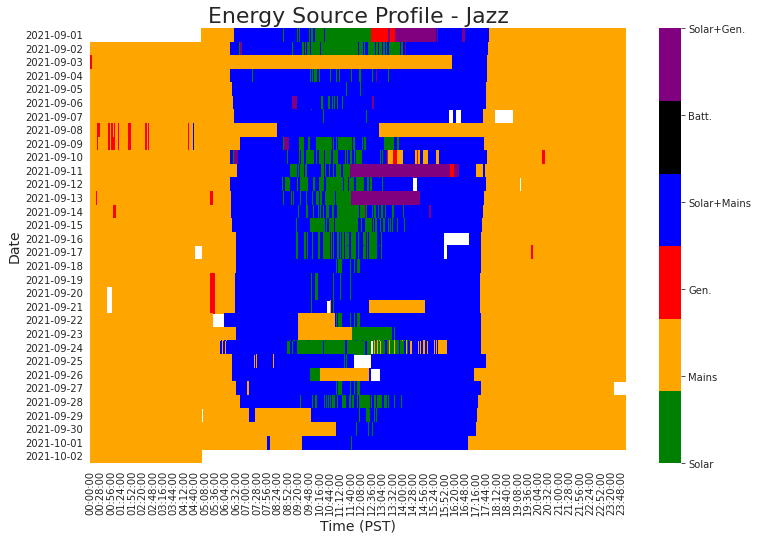

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(12,8))
myColors = ('green', 'orange', 'red', 'blue','black','purple')
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

ax = sns.heatmap(df_PS_jazz,cmap=cmap)
#sns.set_style("whitegrid")

# Specify colorbar labelling 
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1.,2.,3.,4.,5.,6.])
colorbar.set_ticklabels(['Solar', 'Mains', 'Gen.', 'Solar+Mains', 'Batt.','Solar+Gen.'])

# X - Y axis labels
ax.set_ylabel('Date', fontsize= 14)
ax.set_xlabel('Time (PST)', fontsize=14)
ax.set_title('Energy Source Profile - Jazz', fontsize=22)

fig = ax.get_figure()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Load_shedding_Jazz.png')
#sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 1})

#sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 5})



## Fuel Data 


In [ ]:
raw_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/raw_data.csv')
raw_data_df.head()

,DateTime,Date,time,fuel_tank_temp_io7,fuel_sensor_voltage_floatarm_io7,grid_phase_A_current_io3,grid_phsae_A_voltage_io3,gen_run_status_energy_meter5,power_source_energy_meter5,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase_energy_meter6,active_power_A_energy_meter6,voltage_C_energy_meter6,current_B_energy_meter6,power_factor_C_energy_meter6,current_C_energy_meter6,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,power_factor_total_energy_meter6,energy_A_energy_meter6,current_A_energy_meter6,voltage_B_energy_meter6,voltage_A_energy_meter6,energy_B_energy_meter6,active_power_B_energy_meter6,energy_C_energy_meter6,voltage_BC_energy_meter6,average_current_energy_meter6,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status_io3,Input_8_io3,ac_ct_voltage_io3,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status_io3,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltage_io3,Input_5_io3,Input_2_io3,outdoor_temp_io3,dcplant_battery_current_io3,ac_ct_current_io3,Input_4_1_io3,Input_4_1_Anomlous_io3,pak_time
0,2021-09-01 00:00:00,2021-09-01,00:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,0.99,45.71,6.73,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00
1,2021-09-01 00:01:00,2021-09-01,00:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,0.99,45.71,6.14,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00
2,2021-09-01 00:02:00,2021-09-01,00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,0.99,45.71,6.43,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00
3,2021-09-01 00:03:00,2021-09-01,00:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,0.99,45.72,6.56,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00
4,2021-09-01 00:04:00,2021-09-01,00:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,0.99,45.72,6.22,246.39,242.17,20.74,0.79,21.59,425.89,13.85,420.84,0.75,0.75,423.03,877.2,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1230.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,49.20,37.49,38.29,2021-09-01 05:04:00


In [ ]:
fuel_data = raw_data_df[['pak_time','Input_4_1_io3','gen_status_io3']]
# fuel_data = fuel_data.set_index('DateTime')

fuel_data.loc[fuel_data['Input_4_1_io3'] > 41.5, 'Input_4_1_io3'] = 41.5
fuel_data.loc[fuel_data['gen_status_io3'] != 0, 'gen_status_io3'] = 1
fuel_data = fuel_data.dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
fuel_data.head()

,pak_time,Input_4_1_io3,gen_status_io3
0,2021-09-01 05:00:00,37.49,0.0
1,2021-09-01 05:01:00,37.49,0.0
2,2021-09-01 05:02:00,37.49,0.0
3,2021-09-01 05:03:00,37.49,0.0
4,2021-09-01 05:04:00,37.49,0.0


In [ ]:
fuel_data = fuel_data.rename({'pak_time' : 'Pak Date Time', 'Input_4_1_io3':	'Fuel Quantity'	,'gen_status_io3':'Gen Status'	}	, axis = 1)

fuel_data.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Fuel_Data_Jazz_Sept_2021.csv', index = False)

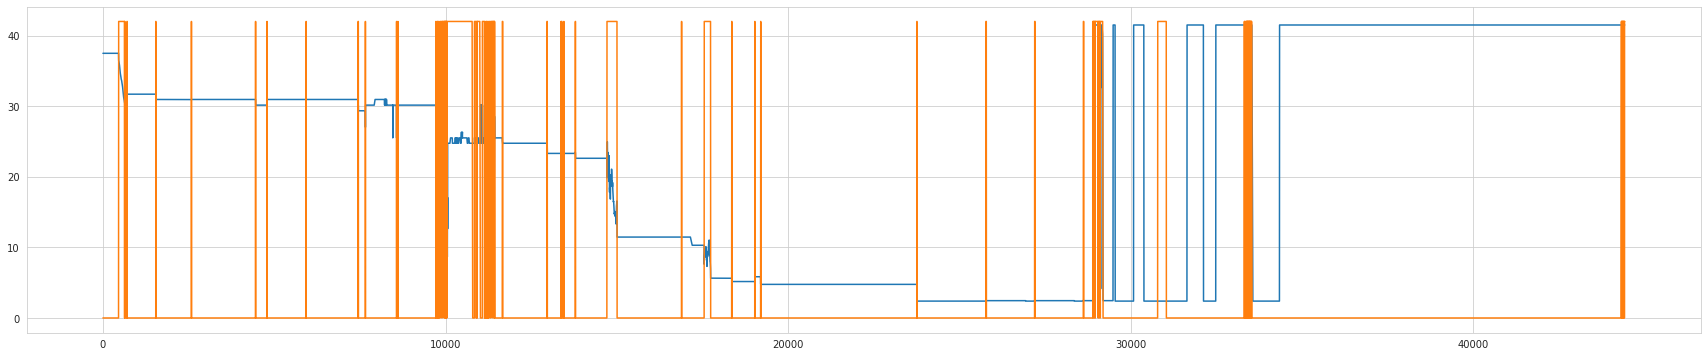

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(fuel_data['Fuel Quantity'], label='Fuel Quantity (Ltrs)')
plt.plot(fuel_data['Gen Status'] , label= 'Gen Status')
# X - Y axis labels

In [ ]:
import math
length = 49.5
diameter = 29.5



In [ ]:
floatarm_df = raw_data_df[['fuel_sensor_voltage_floatarm_io7', 'pak_time']].rename({'fuel_sensor_voltage_floatarm_io7': 'Fuel Voltage FA', 'pak_time': 'Pak DataTime'},axis=1)
floatarm_df['Fuel Quantity FA'] = np.nan
floatarm_df['Fuel Level FA'] = np.nan

for i in range(len(floatarm_df)):
  if str(floatarm_df['Fuel Voltage FA'][0]) == 'nan':
    voltage = floatarm_df['Fuel Voltage FA'][i] 

    floatarm_df['Fuel Level FA'][i]  = ((174.5 * (voltage**2))+((-140.2) * voltage)+61.96)

    floatarm_df['Fuel Quantity FA'][i] =  ( length * ( ((diameter/2) * (diameter/2)) * (math.acos(  (((diameter/2)-(floatarm_df['Fuel Level FA'][i]/25.4))/(diameter/2)) ) ) - ( ((diameter/2)-(floatarm_df['Fuel Level FA'][i]/25.4)) * math.sqrt( ((2 * (diameter/2) * (floatarm_df['Fuel Level FA'][i]/25.4)) - ((floatarm_df['Fuel Level FA'][i]/25.4) *  floatarm_df['Fuel Level FA'][i]/25.4)))  ) ) )  / 61.0237




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
floatarm_df.dropna()

,Fuel Voltage FA,Pak DataTime,Fuel Quantity FA,Fuel Level FA
37706,1.01,2021-09-27 13:03:00,42.961509,98.36545
37707,1.00,2021-09-27 13:04:00,41.627940,96.26000
37708,1.01,2021-09-27 13:05:00,42.961509,98.36545
37709,1.01,2021-09-27 13:06:00,42.961509,98.36545
37711,1.00,2021-09-27 13:08:00,41.627940,96.26000
...,...,...,...,...
44417,0.98,2021-10-02 04:55:00,39.062918,92.15380
44418,0.98,2021-10-02 04:56:00,39.062918,92.15380
44419,0.98,2021-10-02 04:57:00,39.062918,92.15380
44420,0.98,2021-10-02 04:58:00,39.062918,92.15380


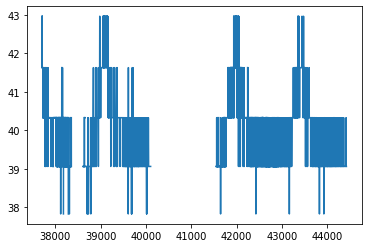

In [ ]:
plt.plot(floatarm_df['Fuel Quantity FA'])

## Solar Consumption

In [ ]:
raw_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/raw_data.csv')
raw_data_df.head()


,DateTime,Date,time,fuel_tank_temp_io7,fuel_sensor_voltage_floatarm_io7,grid_phase_A_current_io3,grid_phsae_A_voltage_io3,gen_run_status_energy_meter5,power_source_energy_meter5,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase_energy_meter6,active_power_A_energy_meter6,voltage_C_energy_meter6,current_B_energy_meter6,power_factor_C_energy_meter6,current_C_energy_meter6,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,power_factor_total_energy_meter6,energy_A_energy_meter6,current_A_energy_meter6,voltage_B_energy_meter6,voltage_A_energy_meter6,energy_B_energy_meter6,active_power_B_energy_meter6,energy_C_energy_meter6,voltage_BC_energy_meter6,average_current_energy_meter6,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status_io3,Input_8_io3,ac_ct_voltage_io3,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status_io3,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltage_io3,Input_5_io3,Input_2_io3,outdoor_temp_io3,dcplant_battery_current_io3,ac_ct_current_io3,Input_4_1_io3,Input_4_1_Anomlous_io3,pak_time
0,2021-09-01 00:00:00,2021-09-01,00:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,0.99,45.71,6.73,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00
1,2021-09-01 00:01:00,2021-09-01,00:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,0.99,45.71,6.14,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00
2,2021-09-01 00:02:00,2021-09-01,00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,0.99,45.71,6.43,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00
3,2021-09-01 00:03:00,2021-09-01,00:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,0.99,45.72,6.56,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00
4,2021-09-01 00:04:00,2021-09-01,00:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,0.99,45.72,6.22,246.39,242.17,20.74,0.79,21.59,425.89,13.85,420.84,0.75,0.75,423.03,877.2,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1230.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,49.20,37.49,38.29,2021-09-01 05:04:00


In [ ]:
solar_data = raw_data_df[['pak_time','solar_power_energy_meter5','solar_plant_voltage_io3','Input_8_io3']]
solar_data = solar_data.fillna(0)
solar_data['pak_time'] = pd.to_datetime(solar_data['pak_time'])


In [ ]:
solar_data['Date'] = (solar_data['pak_time'].dt.date).astype(str)
solar_data['Time'] = solar_data['pak_time'].dt.time

solar_data['time'] = (pd.to_datetime(solar_data['Time'].astype(str).str[:-3]+':00').dt.time).astype(str)
solar_data['hour'] = (pd.to_datetime(solar_data['Time'].astype(str).str[:-6]+':00').dt.time).astype(str)
solar_data.head()

,pak_time,solar_power_energy_meter5,solar_plant_voltage_io3,Input_8_io3,Date,Time,time,hour
0,2021-09-01 05:00:00,0.0,0.0,0.0,2021-09-01,05:00:00,05:00:00,05:00:00
1,2021-09-01 05:01:00,0.0,0.0,0.0,2021-09-01,05:01:00,05:01:00,05:00:00
2,2021-09-01 05:02:00,0.0,0.0,0.0,2021-09-01,05:02:00,05:02:00,05:00:00
3,2021-09-01 05:03:00,0.0,0.0,0.0,2021-09-01,05:03:00,05:03:00,05:00:00
4,2021-09-01 05:04:00,0.0,0.0,0.0,2021-09-01,05:04:00,05:04:00,05:00:00


In [ ]:
solar_data['solar_power_kwh'] = np.nan
solar_data['solar_power_kwh'] = solar_data['solar_power_energy_meter5']/60.0
solar_data.groupby(['Date','hour'])['solar_power_kwh'].sum()

Date        hour    
2021-09-01  05:00:00    0.000000
            06:00:00    0.299167
            07:00:00    1.455333
            08:00:00    2.620333
            09:00:00    3.549167
                          ...   
2021-10-02  00:00:00    0.000000
            01:00:00    0.000000
            02:00:00    0.000000
            03:00:00    0.000000
            04:00:00    0.000000
Name: solar_power_kwh, Length: 744, dtype: float64

In [ ]:
solar_data_kwh = pd.DataFrame(solar_data.groupby(['Date','hour'])['solar_power_energy_meter5'].sum()).reset_index()

solar_data_kwh = solar_data_kwh.rename({'solar_power_energy_meter5': 'Solar Power (kWh)'}, axis = 1)
solar_data_kwh['Solar Power (kWh)'] = solar_data_kwh['Solar Power (kWh)']/60.0 
solar_data_kwh.head()

,Date,hour,Solar Power (kWh)
0,2021-09-01,05:00:00,0.000000
1,2021-09-01,06:00:00,0.299167
2,2021-09-01,07:00:00,1.455333
3,2021-09-01,08:00:00,2.620333
4,2021-09-01,09:00:00,3.549167


In [ ]:
final = solar_data[['pak_time',	'solar_power_energy_meter5',	'solar_plant_voltage_io3',	'Input_8_io3']].rename({'pak_time': 'Pak Date Time', 'solar_power_energy_meter5': 'Solar Power (kW)',	'solar_plant_voltage_io3': 'Solar Voltage',	'Input_8_io3': 'Solar Current'}, axis=1)
final.head()

final.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/solar_data_Jazz.csv', index= False)


In [ ]:
solar_data_kwh

,Date,hour,Solar Power (kWh)
0,2021-09-01,05:00:00,0.000000
1,2021-09-01,06:00:00,0.299167
2,2021-09-01,07:00:00,1.455333
3,2021-09-01,08:00:00,2.620333
4,2021-09-01,09:00:00,3.549167
...,...,...,...
739,2021-10-02,00:00:00,0.000000
740,2021-10-02,01:00:00,0.000000
741,2021-10-02,02:00:00,0.000000
742,2021-10-02,03:00:00,0.000000


In [ ]:
solar_data_kwh['Date'].astype(str)
solar_data_kwh['hour'].astype(str)

solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-22')  & (solar_data_kwh['hour'] =='07:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-21')  & (solar_data_kwh['hour'] =='07:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-22')  & (solar_data_kwh['hour'] =='08:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-21')  & (solar_data_kwh['hour'] =='08:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-22')  & (solar_data_kwh['hour'] =='09:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-21')  & (solar_data_kwh['hour'] =='09:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-23')  & (solar_data_kwh['hour'] =='08:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-03')  & (solar_data_kwh['hour'] =='08:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-23')  & (solar_data_kwh['hour'] =='09:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-03')  & (solar_data_kwh['hour'] =='09:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-23')  & (solar_data_kwh['hour'] =='11:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-03')  & (solar_data_kwh['hour'] =='11:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-23')  & (solar_data_kwh['hour'] =='12:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-03')  & (solar_data_kwh['hour'] =='12:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-23')  & (solar_data_kwh['hour'] =='13:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-02')  & (solar_data_kwh['hour'] =='13:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-23')  & (solar_data_kwh['hour'] =='14:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-02')  & (solar_data_kwh['hour'] =='14:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-23')  & (solar_data_kwh['hour'] =='15:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-02')  & (solar_data_kwh['hour'] =='15:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-24')  & (solar_data_kwh['hour'] =='06:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-12')  & (solar_data_kwh['hour'] =='06:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-24')  & (solar_data_kwh['hour'] =='07:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-12')  & (solar_data_kwh['hour'] =='07:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-24')  & (solar_data_kwh['hour'] =='08:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-12')  & (solar_data_kwh['hour'] =='08:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-24')  & (solar_data_kwh['hour'] =='09:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-12')  & (solar_data_kwh['hour'] =='09:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-24')  & (solar_data_kwh['hour'] =='10:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-12')  & (solar_data_kwh['hour'] =='10:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]
solar_data_kwh.loc[(solar_data_kwh['Date'] =='2021-09-24')  & (solar_data_kwh['hour'] =='11:00:00'),'Solar Power (kWh)' ] = solar_data_kwh[(solar_data_kwh['Date'] =='2021-09-12')  & (solar_data_kwh['hour'] =='11:00:00')]['Solar Power (kWh)' ].reset_index()['Solar Power (kWh)' ][0]


In [ ]:

solar_data_kwh.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/solar_data_KWh_Jazz.csv', index= False)

In [ ]:
# solar_data_kwh['Date'].astype(str)

# solar_data_kwh = solar_data_kwh[(solar_data_kwh['Date'] !='2021-09-22') ]
# solar_data_kwh = solar_data_kwh[(solar_data_kwh['Date'] !='2021-09-23') ]
# solar_data_kwh = solar_data_kwh[(solar_data_kwh['Date'] !='2021-09-24') ]

solar_pt = solar_data_kwh.pivot(index='Date', columns='hour', values='Solar Power (kWh)')
solar_pt

hour,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-01,NaN,NaN,NaN,NaN,NaN,0.0000,0.299167,1.455333,2.620333,3.549167,4.223667,4.016667,4.023667,3.902500,3.285000,2.352833,1.273833,0.329667,0.022667,0.0,0.000000,0.0,0.0,0.0
2021-09-02,0.0,0.000,0.000000,0.000000,0.000000,0.0005,0.357333,1.481000,2.818167,3.575167,4.245000,4.033667,4.151500,4.124833,3.495333,2.456500,1.239000,0.365500,0.015833,0.0,0.000000,0.0,0.0,0.0
2021-09-03,0.0,0.000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600333,0.361333,0.007833,0.0,0.000000,0.0,0.0,0.0
2021-09-04,0.0,0.000,0.000000,0.000000,0.000000,0.0000,0.322167,1.305167,2.503167,3.456667,4.060667,4.143333,3.853833,3.711500,3.228667,2.142500,1.051500,0.308500,0.009833,0.0,0.000000,0.0,0.0,0.0
2021-09-05,0.0,0.000,0.000000,0.000000,0.000000,0.0000,0.222833,0.841000,1.553667,2.842333,3.525500,3.987333,2.912667,2.460167,2.448500,1.649667,0.985000,0.310667,0.007500,0.0,0.000000,0.0,0.0,0.0
2021-09-06,0.0,0.000,0.000000,0.000000,0.000000,0.0000,0.213833,0.995333,2.138833,2.861167,3.490000,4.097333,3.488667,2.386833,2.212667,0.749500,0.638333,0.310667,0.007500,0.0,0.000000,0.0,0.0,0.0
2021-09-07,0.0,0.000,0.000000,0.000000,0.000000,0.0000,0.199833,0.987667,1.986833,2.576500,2.903167,3.748167,2.215500,1.307333,1.649288,2.172732,0.212833,0.160333,0.005667,0.0,0.000000,0.0,0.0,0.0
2021-09-08,0.0,0.000,0.005500,0.000000,0.012833,0.0000,0.000000,0.000000,1.273000,2.017667,1.472333,0.972000,0.474000,0.022500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2021-09-09,0.0,0.000,0.005500,0.000000,0.012833,0.0000,0.077500,0.701333,1.951167,3.155167,4.402833,4.382000,2.084000,3.775000,3.542667,2.445167,1.228833,0.268667,0.004167,0.0,0.000000,0.0,0.0,0.0


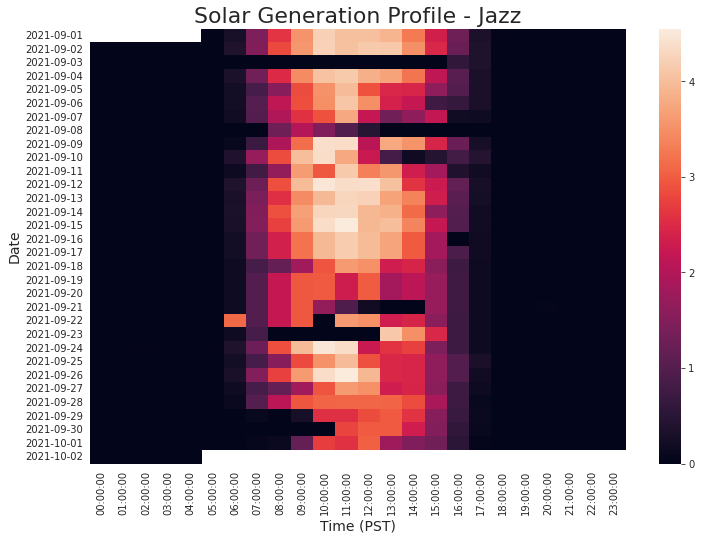

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(12,8))

ax = sns.heatmap(solar_pt)

# X - Y axis labels
ax.set_ylabel('Date', fontsize= 14)
ax.set_xlabel('Time (PST)', fontsize=14)
ax.set_title('Solar Generation Profile - Jazz', fontsize=22)

fig = ax.get_figure()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Solar_generation_jazz.png')
#sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 1})



## Total DC Load Consumption

In [ ]:
raw_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/raw_data.csv')
raw_data_df.head()


,DateTime,Date,time,fuel_tank_temp_io7,fuel_sensor_voltage_floatarm_io7,grid_phase_A_current_io3,grid_phsae_A_voltage_io3,gen_run_status_energy_meter5,power_source_energy_meter5,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase_energy_meter6,active_power_A_energy_meter6,voltage_C_energy_meter6,current_B_energy_meter6,power_factor_C_energy_meter6,current_C_energy_meter6,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,power_factor_total_energy_meter6,energy_A_energy_meter6,current_A_energy_meter6,voltage_B_energy_meter6,voltage_A_energy_meter6,energy_B_energy_meter6,active_power_B_energy_meter6,energy_C_energy_meter6,voltage_BC_energy_meter6,average_current_energy_meter6,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status_io3,Input_8_io3,ac_ct_voltage_io3,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status_io3,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltage_io3,Input_5_io3,Input_2_io3,outdoor_temp_io3,dcplant_battery_current_io3,ac_ct_current_io3,Input_4_1_io3,Input_4_1_Anomlous_io3,pak_time
0,2021-09-01 00:00:00,2021-09-01,00:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,0.99,45.71,6.73,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00
1,2021-09-01 00:01:00,2021-09-01,00:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,0.99,45.71,6.14,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00
2,2021-09-01 00:02:00,2021-09-01,00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,0.99,45.71,6.43,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00
3,2021-09-01 00:03:00,2021-09-01,00:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,0.99,45.72,6.56,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00
4,2021-09-01 00:04:00,2021-09-01,00:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,0.99,45.72,6.22,246.39,242.17,20.74,0.79,21.59,425.89,13.85,420.84,0.75,0.75,423.03,877.2,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1230.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,49.20,37.49,38.29,2021-09-01 05:04:00


In [ ]:
site_load_dc = raw_data_df[['pak_time','total_instantaneous_real_power_energy_meter6']]
site_load_dc = site_load_dc.fillna(0)
site_load_dc['pak_time'] = pd.to_datetime(site_load_dc['pak_time'])


In [ ]:
site_load_dc['Date'] = (site_load_dc['pak_time'].dt.date).astype(str)
site_load_dc['Time'] = site_load_dc['pak_time'].dt.time

site_load_dc['time'] = (pd.to_datetime(site_load_dc['Time'].astype(str).str[:-3]+':00').dt.time).astype(str)
site_load_dc['hour'] = (pd.to_datetime(site_load_dc['Time'].astype(str).str[:-6]+':00').dt.time).astype(str)
site_load_dc.head()

,pak_time,total_instantaneous_real_power_energy_meter6,Date,Time,time,hour
0,2021-09-01 05:00:00,3.21,2021-09-01,05:00:00,05:00:00,05:00:00
1,2021-09-01 05:01:00,2.96,2021-09-01,05:01:00,05:01:00,05:00:00
2,2021-09-01 05:02:00,3.11,2021-09-01,05:02:00,05:02:00,05:00:00
3,2021-09-01 05:03:00,3.10,2021-09-01,05:03:00,05:03:00,05:00:00
4,2021-09-01 05:04:00,3.03,2021-09-01,05:04:00,05:04:00,05:00:00


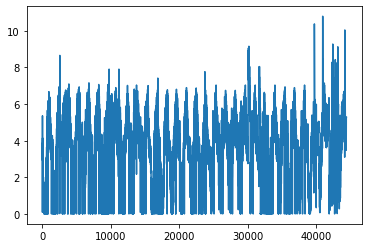

In [ ]:
plt.plot(site_load_dc['total_instantaneous_real_power_energy_meter6'])

In [ ]:
site_load_dc_kwh = pd.DataFrame(site_load_dc.groupby(['Date','hour'])['total_instantaneous_real_power_energy_meter6'].sum()).reset_index()

site_load_dc_kwh = site_load_dc_kwh.rename({'total_instantaneous_real_power_energy_meter6': 'Total Power (kWh)'}, axis = 1)
site_load_dc_kwh['Total Power (kWh)'] = site_load_dc_kwh['Total Power (kWh)']/60.0 
site_load_dc_kwh.head()

,Date,hour,Total Power (kWh)
0,2021-09-01,05:00:00,2.902333
1,2021-09-01,06:00:00,3.316167
2,2021-09-01,07:00:00,2.200833
3,2021-09-01,08:00:00,1.094167
4,2021-09-01,09:00:00,0.495667


In [ ]:
# solar_data_kwh['Date'].astype(str)

# solar_data_kwh = solar_data_kwh[(solar_data_kwh['Date'] !='2021-09-22') ]
# solar_data_kwh = solar_data_kwh[(solar_data_kwh['Date'] !='2021-09-23') ]
# solar_data_kwh = solar_data_kwh[(solar_data_kwh['Date'] !='2021-09-24') ]

site_load_dc_kwh_pt = site_load_dc_kwh.pivot(index='Date', columns='hour', values='Total Power (kWh)')
site_load_dc_kwh_pt

hour,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-01,NaN,NaN,NaN,NaN,NaN,2.902333,3.316167,2.200833,1.094167,0.495667,0.322833,0.025500,0.031667,0.498333,1.272333,2.181000,3.204333,4.164000,4.325500,4.782000,5.128833,5.359667,5.531333,5.348667
2021-09-02,4.924167,4.196333,3.679000,3.223667,3.147167,3.323500,3.211333,2.081500,1.343333,0.469833,0.136333,0.026833,0.450167,0.278833,1.486333,2.696833,3.342667,4.002667,4.265167,4.638833,5.087833,5.450000,5.741833,5.308833
2021-09-03,5.369333,4.653167,3.955333,3.584667,3.484000,3.612000,3.980833,3.950000,4.560000,4.580333,5.044167,5.303833,5.260167,5.172000,5.603000,5.717000,4.449833,4.234167,4.446500,4.791167,5.060667,5.918833,5.975833,5.518667
2021-09-04,4.980667,4.467333,4.101667,3.192833,3.261500,3.160833,2.999167,2.235333,1.719167,1.056333,0.809333,0.739167,1.162000,1.308167,2.232333,3.430500,4.397167,4.976667,5.293000,5.315333,5.494333,5.706167,5.706833,5.796333
2021-09-05,5.593500,4.832167,4.124167,3.622833,3.261500,3.486667,3.350667,2.881000,2.566500,1.500667,1.214833,1.225667,2.118667,2.583667,2.814167,3.585833,4.142167,4.534833,4.597500,5.270333,5.216833,5.421167,6.011500,5.859000
2021-09-06,5.159833,4.711833,3.639000,3.446833,3.325167,3.339500,3.351667,2.752500,1.828833,1.321333,0.851500,0.820667,1.811167,2.301333,3.074167,4.357833,4.452000,4.534833,4.597500,5.270333,5.216833,5.421167,5.955500,4.867167
2021-09-07,5.311167,4.668667,3.851667,3.460167,3.395667,3.384000,3.144333,2.706333,2.167167,1.549500,1.644667,1.096833,2.682000,3.396333,3.194000,2.450833,1.931667,3.810500,0.644667,4.424667,4.772000,5.274333,5.648833,5.515833
2021-09-08,4.522167,4.695667,4.104333,3.997000,3.838167,5.276500,5.240333,5.349167,3.615167,2.606500,3.452333,3.992500,4.111667,4.443667,5.142833,4.847833,5.284667,5.664000,5.603667,5.250667,4.569167,3.914167,3.346000,3.145167
2021-09-09,4.522167,4.662333,4.104333,3.997000,3.803000,2.925500,3.590667,2.891000,2.082667,1.169500,0.294667,0.408333,2.667833,0.604833,1.173333,2.205833,3.295000,3.985167,4.345000,4.772167,4.962667,5.409000,5.640667,5.135000


Text(0.5, 1.0, 'Total DC Load Profile - Jazz')

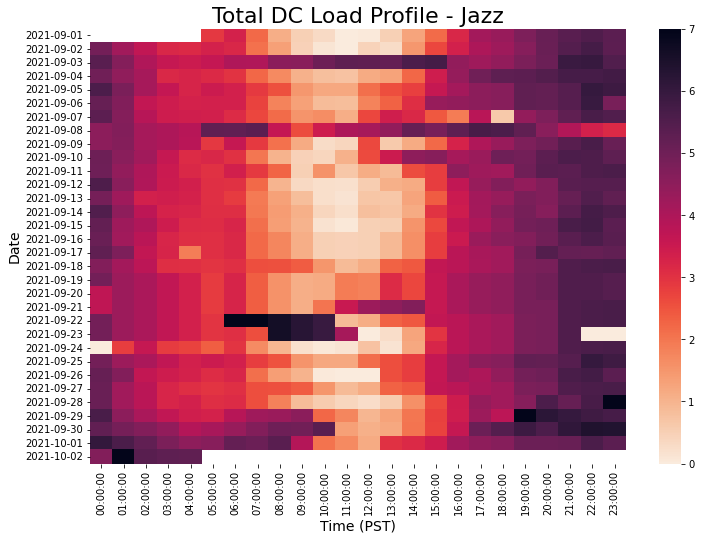

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(12,8))
cmap1 = sns.cm.rocket_r
# reversed_color_map = color_map.reversed()
ax = sns.heatmap(site_load_dc_kwh_pt, cmap=cmap1, vmax = 7)

# X - Y axis labels
ax.set_ylabel('Date', fontsize= 14)
ax.set_xlabel('Time (PST)', fontsize=14)
ax.set_title('Total DC Load Profile - Jazz', fontsize=22)

# fig = ax.get_figure()
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/total_DC_Load_jazz.png')
#sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 1})



In [ ]:
site_load_dc.head()

,pak_time,total_instantaneous_real_power_energy_meter6,Date,Time,time,hour
0,2021-09-01 05:00:00,3.21,2021-09-01,05:00:00,05:00:00,05:00:00
1,2021-09-01 05:01:00,2.96,2021-09-01,05:01:00,05:01:00,05:00:00
2,2021-09-01 05:02:00,3.11,2021-09-01,05:02:00,05:02:00,05:00:00
3,2021-09-01 05:03:00,3.10,2021-09-01,05:03:00,05:03:00,05:00:00
4,2021-09-01 05:04:00,3.03,2021-09-01,05:04:00,05:04:00,05:00:00


In [ ]:
site_load_dc_kwh.head()

,Date,hour,Total Power (kWh)
0,2021-09-01,05:00:00,2.902333
1,2021-09-01,06:00:00,3.316167
2,2021-09-01,07:00:00,2.200833
3,2021-09-01,08:00:00,1.094167
4,2021-09-01,09:00:00,0.495667


In [ ]:
final = site_load_dc[['pak_time',	'total_instantaneous_real_power_energy_meter6']].rename({'pak_time': 'Pak Date Time', 'total_instantaneous_real_power_energy_meter6': 'Total Power (kW)'}, axis=1)
final.head()

final.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/site_load_dc_Jazz.csv', index= False)

site_load_dc_kwh.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/site_load_dc_KWh_Jazz.csv', index= False)

# Data Grouping

Total samples per day for all sites

In [ ]:
grouped_df1 = pd.DataFrame(df_jazz.groupby(["Power_State","new_date"])['new_time'].count())
from IPython.core.display import HTML
display(HTML(grouped_df1.to_html()))

In [ ]:
grouped_df1.unstack()

new_time                        ...                                 
new_date    2021-09-01 2021-09-02 2021-09-03  ... 2021-09-30 2021-10-01 2021-10-02
Power_State                                   ...                                 
1.0              148.0      205.0        NaN  ...        5.0        4.0        NaN
2.0              428.0      717.0     1277.0  ...     1053.0      981.0      300.0
3.0               48.0        NaN        4.0  ...        NaN        NaN        NaN
4.0              317.0      453.0       88.0  ...      362.0      451.0        NaN
5.0                NaN        NaN        NaN  ...        NaN        NaN        NaN
6.0              120.0        6.0        NaN  ...        NaN        NaN        NaN

[6 rows x 32 columns]

Daily duration of power sources

In [ ]:
grouped_df = pd.DataFrame(df_jazz.groupby(["Power_State","new_date"])['DailyDuration'].sum())
from IPython.core.display import HTML
display(HTML(grouped_df.to_html()))

In [ ]:
grouped_df.unstack()

DailyDuration             ...                      
new_date       2021-09-01 2021-09-02  ... 2021-10-01 2021-10-02
Power_State                           ...                      
1.0                8880.0    12300.0  ...      240.0        NaN
2.0               25620.0    43020.0  ...    58860.0    18000.0
3.0                2880.0        NaN  ...        NaN        NaN
4.0               19020.0    27180.0  ...    27060.0        NaN
5.0                   NaN        NaN  ...        NaN        NaN
6.0                7200.0      360.0  ...        NaN        NaN

[6 rows x 32 columns]

# Hourly Profiling

In [ ]:
df_jazz.head()

,pak_time,DateTime,new_date,new_time,fuel_tank_temp,fuel_sensor_voltage_FA,grid_phase_A_current,grid_phsae_A_voltage,gen_run_status_energy_meter5,Power_State,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase,active_power_A_energy_meter6,voltage_C,current_B,power_factor_C_energy_meter6,current_C,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,...,current_A,voltage_B,voltage_A,energy_B,active_power_B_energy_meter6,energy_C,voltage_BC_energy_meter6,average_current,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status,Input_8_io3,ac_ct_voltage,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltag,Input_5_io3,Input_2_io3,outdoor_temp,dcplant_battery_current_io3,ac_ct_current,Input_4_1_io3,Input_4_1_Anomlous_io3,index1,Operation_Time,Operation_Time_Seconds,Operation_Time_Hours,Time,event,DailyDuration
0,2021-09-01 05:00:00,2021-09-01 00:00:00,2021-09-01,05:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,...,6.73,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00,NaN,NaN,NaN,05:00:00,0.0,NaN
1,2021-09-01 05:01:00,2021-09-01 00:01:00,2021-09-01,05:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,...,6.14,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00,0 days 00:01:00,60.0,0.016667,05:01:00,0.0,60.0
2,2021-09-01 05:02:00,2021-09-01 00:02:00,2021-09-01,05:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,...,6.43,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00,0 days 00:01:00,60.0,0.016667,05:02:00,1.0,60.0
3,2021-09-01 05:03:00,2021-09-01 00:03:00,2021-09-01,05:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,...,6.56,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00,0 days 00:01:00,60.0,0.016667,05:03:00,2.0,NaN
4,2021-09-01 05:04:00,2021-09-01 00:04:00,2021-09-01,05:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,...,6.22,246.39,242.17,20.74,0.79,21.59,425.89,13.85,420.84,0.75,0.75,423.03,877.2,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1230.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,49.20,3

In [ ]:

profile_df = pd.DataFrame(columns = ["Power_State", "Desc","Count"])

df_jazz = df_jazz.set_index('pak_time')
df_jazz = df_jazz.sort_index()
df_DD = df_jazz
df_DD = (df_DD[df_DD['DailyDuration'].notna()])
df_DD = df_DD[["new_date" ,"Power_State","DailyDuration"]]
df_DD['HourlyDailyDuration'] = df_DD['DailyDuration']/3600


In [ ]:
df_DD.head()

,new_date,Power_State,DailyDuration,HourlyDailyDuration
pak_time,,,,
2021-09-01 05:01:00,2021-09-01,2.0,60.0,0.016667
2021-09-01 05:02:00,2021-09-01,NaN,60.0,0.016667
2021-09-01 06:27:00,2021-09-01,2.0,5100.0,1.416667
2021-09-01 07:27:00,2021-09-01,4.0,3600.0,1.000000
2021-09-01 07:28:00,2021-09-01,NaN,60.0,0.016667


In [ ]:
grouped_df = df_DD
for i in grouped_df['Power_State'].unique():
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 0 - 1 Hour',"Count":      len(grouped_df[(grouped_df['HourlyDailyDuration'] < 1) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 1 - 2 Hour',"Count":   len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 1) & (grouped_df['HourlyDailyDuration'] < 2) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 2 - 3 Hour',"Count":   len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 2) & (grouped_df['HourlyDailyDuration'] < 3) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 3 - 4 Hour',"Count":   len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 3) & (grouped_df['HourlyDailyDuration'] < 4) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 4 - 5 Hour',"Count":   len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 4) & (grouped_df['HourlyDailyDuration'] < 5) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 5 - 6 Hour',"Count":   len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 5) & (grouped_df['HourlyDailyDuration'] < 6) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 6 - 7 Hour',"Count":   len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 6) & (grouped_df['HourlyDailyDuration'] < 7) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 7 - 8 Hour',"Count":   len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 7) & (grouped_df['HourlyDailyDuration'] < 8) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 8 - 9 Hour',"Count":   len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 8) & (grouped_df['HourlyDailyDuration'] < 9) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 9 - 10 Hour',"Count" : len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 9) & (grouped_df['HourlyDailyDuration'] < 10) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 10 - 11 Hour',"Count": len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 10) & (grouped_df['HourlyDailyDuration'] < 11) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
  profile_df = profile_df.append({"Power_State": i,"Desc": ' 11 - 24 Hour',"Count":     len(grouped_df[(grouped_df['HourlyDailyDuration'] >= 11) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)     

In [ ]:
profile_df.head()

,Power_State,Desc,Count
0,2.0,0 - 1 Hour,938
1,2.0,1 - 2 Hour,48
2,2.0,2 - 3 Hour,25
3,2.0,3 - 4 Hour,4
4,2.0,4 - 5 Hour,3


In [ ]:
profile_df = profile_df.dropna()
profile_df['Power_Source'] = np.nan

profile_df.loc[(profile_df['Power_State'] == 1.0),'Power_Source'] = 'Solar'
profile_df.loc[(profile_df['Power_State'] == 2.0),'Power_Source'] = 'Mains'
profile_df.loc[(profile_df['Power_State'] == 3.0),'Power_Source'] = 'Generator'
profile_df.loc[(profile_df['Power_State'] == 4.0),'Power_Source'] = 'Solar+Mains'  
profile_df.loc[(profile_df['Power_State'] == 5.0),'Power_Source'] = 'Battery' 
profile_df.loc[(profile_df['Power_State'] == 6.0),'Power_Source'] = 'Solar+Gen'

In [ ]:

profile_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Hourly_Profiling_Jazz_Site.csv', index=False)

# Daywise Hourly Profiling

In [ ]:
df_jazz['Load_Shedding'] = df_jazz['Power_State']
df_jazz.loc[((df_jazz['Power_State'] == 3) | (df_jazz['Power_State'] == 5) | (df_jazz['Power_State'] == 6)), 'Load_Shedding'] = 'Load Shedding'


In [ ]:
profile_df = pd.DataFrame(columns = ["Power_State", "Desc","Count"])


df_jazz = df_jazz.sort_index()
df_DD = df_jazz
grouped_df = pd.DataFrame(df_DD.groupby(["new_date" ,'event',"Power_State"])['DailyDuration'].sum())
grouped_df = grouped_df.reset_index()
grouped_df['HourlyDailyDuration'] = grouped_df['DailyDuration']/3600
for j in grouped_df['new_date'].unique():
  for i in grouped_df['Power_State'].unique():
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 0 - .5 Hour',"Date":j, "Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] < 0.5) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' .5 - 1 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 0.5) & (grouped_df['HourlyDailyDuration'] < 1) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 1 - 2 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 1) & (grouped_df['HourlyDailyDuration'] < 2) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 2 - 3 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 2) & (grouped_df['HourlyDailyDuration'] < 3) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 3 - 4 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 3) & (grouped_df['HourlyDailyDuration'] < 4) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 4 - 5 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 4) & (grouped_df['HourlyDailyDuration'] < 5) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 5 - 6 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 5) & (grouped_df['HourlyDailyDuration'] < 6) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 6 - 7 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 6) & (grouped_df['HourlyDailyDuration'] < 7) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 7 - 8 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 7) & (grouped_df['HourlyDailyDuration'] < 8) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 8 - 9 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 8) & (grouped_df['HourlyDailyDuration'] < 9) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 9 - 10 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 9) & (grouped_df['HourlyDailyDuration'] < 10) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 10 - 11 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 10) & (grouped_df['HourlyDailyDuration'] < 11) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
      profile_df = profile_df.append({"Power_State": i,"Desc": ' 11 - 24 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 11) & (grouped_df['Power_State'] == i) ])}, ignore_index=True)
# 

In [ ]:
profile_df = profile_df.dropna()
profile_df['Power_Source'] = np.nan

profile_df.loc[(profile_df['Power_State'] == 1.0),'Power_Source'] = 'Solar'
profile_df.loc[(profile_df['Power_State'] == 2.0),'Power_Source'] = 'Mains'
profile_df.loc[(profile_df['Power_State'] == 3.0),'Power_Source'] = 'Generator'
profile_df.loc[(profile_df['Power_State'] == 4.0),'Power_Source'] = 'Solar+Mains'
profile_df.loc[(profile_df['Power_State'] == 5.0),'Power_Source'] = 'Battery'
profile_df.loc[(profile_df['Power_State'] == 6.0),'Power_Source'] = 'Solar+Gen'

In [ ]:
profile_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Hourly_Profiling_Daywise_Jazz_Site.csv', index=False)

In [ ]:
profile_df.head()

,Power_State,Desc,Count,Date,Power_Source
0,2.0,0 - .5 Hour,22,2021-09-01,Mains
1,2.0,.5 - 1 Hour,2,2021-09-01,Mains
2,2.0,1 - 2 Hour,2,2021-09-01,Mains
3,2.0,2 - 3 Hour,0,2021-09-01,Mains
4,2.0,3 - 4 Hour,0,2021-09-01,Mains


In [ ]:
df_DD.head()

,DateTime,new_date,new_time,fuel_tank_temp,fuel_sensor_voltage_FA,grid_phase_A_current,grid_phsae_A_voltage,gen_run_status_energy_meter5,Power_State,solar_power_energy_meter5,voltage_L2_energy_meter5,Input_8_energy_meter5,dc_voltage_energy_meter5,average_current_energy_meter5,ac_ct_current_energy_meter5,gen_status_energy_meter5,average_voltage_phase_to_phase_energy_meter5,energy_total_energy_meter5,current_B_energy_meter5,stream_power_source_energy_meter5,current_C_energy_meter5,total_power_energy_meter5,current_A_energy_meter5,Voltage_L1_energy_meter5,dcplant_battery_current_energy_meter5,battery_bank_power_energy_meter5,apparent_power_B_energy_meter6,power_factor_B_energy_meter6,average_voltage_phase_to_phase,active_power_A_energy_meter6,voltage_C,current_B,power_factor_C_energy_meter6,current_C,power_factor_A_energy_meter6,frequency_energy_meter6,apparent_power_A_energy_meter6,apparent_power_total_energy_meter6,total_instantaneous_real_power_energy_meter6,power_factor_total_energy_meter6,...,voltage_B,voltage_A,energy_B,active_power_B_energy_meter6,energy_C,voltage_BC_energy_meter6,average_current,voltage_AC_energy_meter6,apparent_power_C_energy_meter6,active_power_C_energy_meter6,voltage_AB_energy_meter6,energy_total_energy_meter6,gen_run_status,Input_8_io3,ac_ct_voltage,dcplant_rectifier_current_io3,genset_start_io3,dcrectifier_voltage_io3,gen_status,dc_voltage_io3,Input_7_io3,Input_4_io3,Input_6_io3,genset_battery_voltage_io3,solar_plant_voltag,Input_5_io3,Input_2_io3,outdoor_temp,dcplant_battery_current_io3,ac_ct_current,Input_4_1_io3,Input_4_1_Anomlous_io3,index1,Operation_Time,Operation_Time_Seconds,Operation_Time_Hours,Time,event,DailyDuration,Load_Shedding
pak_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-01 05:00:00,2021-09-01 00:00:00,2021-09-01,05:00:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.4,12.78,51.56,0.0,424.55,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.81,0.99,424.55,1.62,245.29,3.28,0.99,3.27,0.99,49.82,1.63,3.25,3.21,0.99,...,247.16,242.88,20.74,0.80,21.59,427.14,12.78,422.29,0.80,0.79,424.22,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1171.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.7,46.84,37.49,38.29,2021-09-01 05:00:00,NaN,NaN,NaN,05:00:00,0.0,NaN,2
2021-09-01 05:01:00,2021-09-01 00:01:00,2021-09-01,05:01:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.60,47.24,0.0,423.75,877.0,5.97,2.0,6.07,0.0,12.65,219.6,3.1,0.0,0.73,0.99,424.59,1.48,245.23,2.97,0.99,3.11,0.99,49.79,1.49,2.98,2.96,0.99,...,247.19,242.98,20.74,0.73,21.59,427.17,13.60,422.23,0.76,0.76,424.38,877.0,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1181.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.1,47.24,37.49,38.29,2021-09-01 05:01:00,0 days 00:01:00,60.0,0.016667,05:01:00,0.0,60.0,2
2021-09-01 05:02:00,2021-09-01 00:02:00,2021-09-01,05:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0.99,423.75,1.55,244.76,3.19,0.99,3.22,0.99,49.68,1.56,3.13,3.11,0.99,...,246.69,242.50,20.74,0.78,21.59,426.31,12.84,421.41,0.79,0.78,423.52,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1186.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,3.5,47.44,37.49,38.29,2021-09-01 05:02:00,0 days 00:01:00,60.0,0.016667,05:02:00,1.0,60.0,NaN
2021-09-01 05:03:00,2021-09-01 00:03:00,2021-09-01,05:03:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.69,51.56,0.0,423.34,877.1,5.97,2.0,6.07,0.0,12.65,219.6,4.0,212.8,0.74,0.99,423.34,1.58,244.51,3.02,0.99,3.24,0.99,49.66,1.59,3.12,3.10,0.99,...,246.60,242.13,20.74,0.74,21.59,426.01,13.69,420.87,0.79,0.79,423.14,877.1,0.0,0.0,0.0,0.0,0.0,526.0,0.0,53.2,1289.0,90.9,0.0,12.37,0.0,0.0,78.32,25.5,4.0,51.56,37.49,38.29,2021-09-01 05:03:00,0 days 00:01:00,60.0,0.016667,05:03:00,2.0,NaN,2
2021-09-01 05:04:00,2021-09-01 00:04:00,2021-09-01,05:04:00,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,53.2,13.85,49.20,0.0,423.25,877.2,5.97,2.0,6.07,0.0,12.65,219.6,3.7,0.0,0.79,0.99,423.25,1.49,244.53,3.23,0.99,3.09,0.99,49.68,1.50,3.05,3.03,0.99,...,246.39,242.17,20.74,0.79,21.59,425.89,13.85

In [ ]:
load_profile_df = pd.DataFrame(columns = ["Power_State", "Desc","Count"])

df_jazz = df_jazz.sort_index()
df_DD = df_jazz

grouped_df = pd.DataFrame(df_DD.groupby(["new_date" ,'event',"Load_Shedding"])['DailyDuration'].sum())
grouped_df.head()

DailyDuration
new_date   event Load_Shedding               
2021-09-01 0.0   2.0                     60.0
           2.0   2.0                   5100.0
           3.0   4.0                   3600.0
           5.0   4.0                    660.0
           7.0   4.0                   1920.0

In [ ]:
grouped_df = grouped_df.reset_index()
grouped_df['HourlyDailyDuration'] = grouped_df['DailyDuration']/3600
for j in grouped_df['new_date'].unique():
  for i in grouped_df['Load_Shedding'].unique():
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 0 - .5 Hour',"Date":j, "Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] < 0.5) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' .5 - 1 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 0.5) & (grouped_df['HourlyDailyDuration'] < 1) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 1 - 2 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 1) & (grouped_df['HourlyDailyDuration'] < 2) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 2 - 3 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 2) & (grouped_df['HourlyDailyDuration'] < 3) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 3 - 4 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 3) & (grouped_df['HourlyDailyDuration'] < 4) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 4 - 5 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 4) & (grouped_df['HourlyDailyDuration'] < 5) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 5 - 6 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 5) & (grouped_df['HourlyDailyDuration'] < 6) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 6 - 7 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 6) & (grouped_df['HourlyDailyDuration'] < 7) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 7 - 8 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 7) & (grouped_df['HourlyDailyDuration'] < 8) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 8 - 9 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 8) & (grouped_df['HourlyDailyDuration'] < 9) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 9 - 10 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 9) & (grouped_df['HourlyDailyDuration'] < 10) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 10 - 11 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 10) & (grouped_df['HourlyDailyDuration'] < 11) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)
      load_profile_df = load_profile_df.append({"Power_State": i,"Desc": ' 11 - 12 Hour',"Date":j,"Count":len(grouped_df[(grouped_df['new_date'] == j) & (grouped_df['HourlyDailyDuration'] >= 11) & (grouped_df['Load_Shedding'] == i) ])}, ignore_index=True)

In [ ]:
grouped_df['Load_Shedding'].unique()

array([2.0, 4.0, 1.0, 'Load Shedding'], dtype=object)

In [ ]:
load_profile_df.head()

,Power_State,Desc,Count,Date
0,2,0 - .5 Hour,22,2021-09-01
1,2,.5 - 1 Hour,2,2021-09-01
2,2,1 - 2 Hour,2,2021-09-01
3,2,2 - 3 Hour,0,2021-09-01
4,2,3 - 4 Hour,0,2021-09-01


In [ ]:
load_profile_df['Power_State'].unique()

array([2.0, 4.0, 1.0, 'Load Shedding'], dtype=object)

In [ ]:
final_profile_df = pd.concat([load_profile_df,profile_df]).sort_values(["Date","Power_State","Desc"])
final_profile_df.head()

,Power_State,Desc,Count,Date,Power_Source
27,1,.5 - 1 Hour,0,2021-09-01,NaN
27,1,.5 - 1 Hour,0,2021-09-01,Solar
26,1,0 - .5 Hour,29,2021-09-01,NaN
26,1,0 - .5 Hour,29,2021-09-01,Solar
28,1,1 - 2 Hour,0,2021-09-01,NaN


In [ ]:

final_profile_df['Power_Source'] = np.nan

final_profile_df.loc[(final_profile_df['Power_State'] == 1.0),'Power_Source'] = 'Solar'
final_profile_df.loc[(final_profile_df['Power_State'] == 2.0),'Power_Source'] = 'Mains'
final_profile_df.loc[(final_profile_df['Power_State'] == 3.0),'Power_Source'] = 'Generator'
final_profile_df.loc[(final_profile_df['Power_State'] == 4.0),'Power_Source'] = 'Solar+Mains'  
final_profile_df.loc[(final_profile_df['Power_State'] == 5.0),'Power_Source'] = 'Battery'
final_profile_df.loc[(final_profile_df['Power_State'] == 6.0),'Power_Source'] = 'Solar+Gen'
final_profile_df.loc[(final_profile_df['Power_State'] == 'Load Shedding'),'Power_Source'] = 'Load Shedding'

# 

In [ ]:
final_profile_df  = final_profile_df.drop_duplicates().reset_index(drop = True)

In [ ]:
final_profile_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Hourly_Profiling_Daywise_Load_Shedding_Jazz_Site.csv', index=False)

## Filtered Fuel Data

In [ ]:
filtered_fuel_data = raw_data_df[['pak_time', 'Input_4_1_Filtered_io3','gen_status_io3','Date']].dropna()
filtered_fuel_data['Date'] = filtered_fuel_data['Date'].astype(str)
filtered_fuel_data.loc[(filtered_fuel_data['gen_status_io3']== 0 ),'gen_status_io3'] = 0
filtered_fuel_data.loc[(filtered_fuel_data['gen_status_io3']!= 0),'gen_status_io3'] = 1
filtered_fuel_data.loc[(filtered_fuel_data['Date'] == '2021-09-23'),'gen_status_io3'] = 0
filtered_fuel_data.loc[(filtered_fuel_data['Date'] == '2021-09-24'),'gen_status_io3'] = 0
filtered_fuel_data.loc[(filtered_fuel_data['Date'] == '2021-09-25'),'gen_status_io3'] = 0


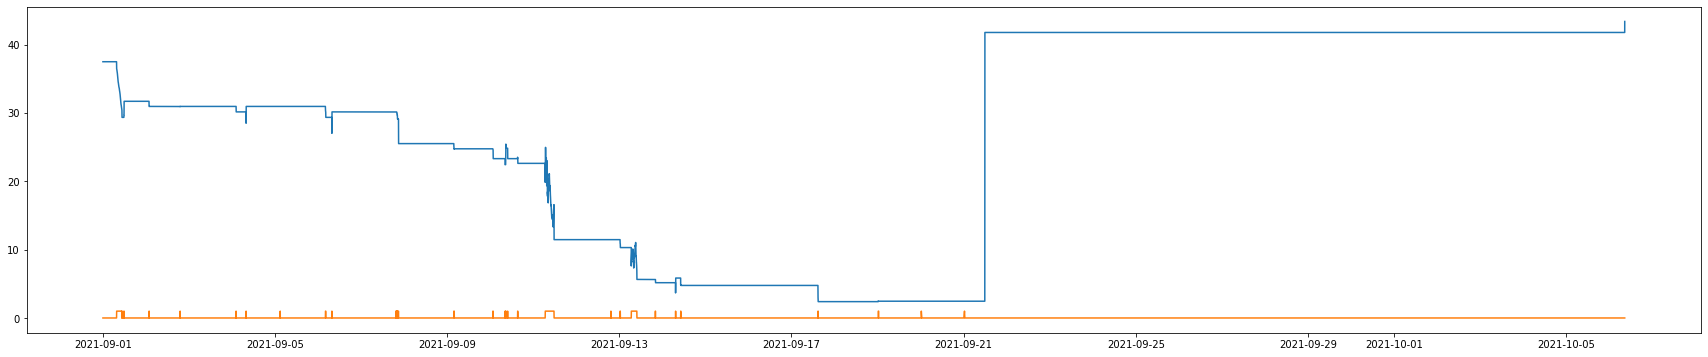

In [ ]:

plt.figure(figsize=(30,6))
plt.plot(filtered_fuel_data['Input_4_1_Filtered_io3'],  label='Fuel Quantity (Ltrs)')
plt.plot(filtered_fuel_data['gen_status_io3'] , label= 'Gen Status')
# X - Y axis labels


In [ ]:
filtered_fuel_data = filtered_fuel_data[['Input_4_1_Filtered_io3','gen_status_io3','pak_time']].rename({'Input_4_1_Filtered_io3':'Fuel Quantity','gen_status_io3': 'Gen Status','pak_time':'Pak Date Time'}, axis=1)
filtered_fuel_data.to_csv('/content/drive/MyDrive/Colab Notebooks/Jazz Site Data Visualization/Filtered_Fuel_Data_Jazz_Sept_2021.csv', index = False)
